# LLM vs RAG: Q&A and Summarization Experiments

This notebook implements a reproducible comparison of:

- **LLM baseline** (no retrieval)
- **RAG-BM25** (sparse retrieval)
- **RAG-Dense** (SentenceTransformers retrieval)

on two tasks:

- **Question Answering (Q&A)** using a small **SQuAD** subset
- **Document summarization** using a small **CNN/DailyMail** subset

## Research questions (explicit)
1. Does RAG improve answer correctness compared to a standalone LLM?
2. Does RAG reduce hallucinations in Q&A and summarization tasks?
3. How do BM25 and dense retrieval differ in performance?
4. Are automatic metrics aligned with manual evaluation?

> For coursework scale we use small dataset subsets with fixed seeds. Increase sizes only after the pipeline is working.


In [1]:
# Setup & imports

import os
from pathlib import Path

import numpy as np
import pandas as pd

from llm_rag_qna.utils import ensure_dir, read_jsonl, set_seed
from llm_rag_qna.chunking import chunk_corpus, simple_word_chunks
from llm_rag_qna.retrievers import BM25Retriever, DenseRetriever
from llm_rag_qna.generator import HFText2TextGenerator, GenerationConfig
from llm_rag_qna.pipeline import (
    RAGConfig,
    answer_qa_llm,
    answer_qa_rag,
    summarize_llm,
    summarize_rag_over_article,
)
from llm_rag_qna.evaluation import (
    qa_accuracy,
    compute_bleu,
    compute_rouge,
    compute_bertscore,
    manual_label_to_numeric,
    correlation_manual_vs_metric,
)
from llm_rag_qna import viz

pd.set_option("display.max_colwidth", 120)


In [2]:
# Experiment configuration (edit these first)

SEED = 13
set_seed(SEED)

# --- Robust project root detection ---
# Notebooks often run with cwd = notebooks/, which breaks relative paths like "data/...".
# This finds the repo root by searching upward for `pyproject.toml` (or `.git`).

def find_project_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / "pyproject.toml").exists() or (p / ".git").exists():
            return p
    return start

PROJECT_ROOT = find_project_root(Path.cwd())
print("PROJECT_ROOT:", PROJECT_ROOT)

# Dataset paths produced by: `python -m scripts.download_data`
DATA_DIR = PROJECT_ROOT / "data" / "processed"
QA_QUESTIONS_PATH = DATA_DIR / "qa_questions.jsonl"
QA_CORPUS_PATH = DATA_DIR / "qa_corpus.jsonl"
SUM_ARTICLES_PATH = DATA_DIR / "sum_articles.jsonl"

# Chunking strategy
# - word-based chunking is easy to describe and reproduce
CHUNK_WORDS = 200
OVERLAP_WORDS = 50

# Retrieval
TOP_K = 5
DENSE_MODEL = "sentence-transformers/all-MiniLM-L6-v2"

# Generator (same for baseline and RAG)
GEN_MODEL = "google/flan-t5-small"  # switch to flan-t5-base for better quality
GEN_CFG = GenerationConfig(max_new_tokens=128, temperature=0.0, top_p=1.0)

# Metrics (BERTScore model can be heavy; choose a smaller one if needed)
BERTSCORE_MODEL = "distilroberta-base"

# Output files for tables / annotation
OUT_DIR = ensure_dir(PROJECT_ROOT / "outputs")


PROJECT_ROOT: d:\FAKS\Opj\LLM_RAG_QnA


## Dataset preparation

If you have not downloaded the datasets yet, run in a terminal:

```bash
python -m scripts.download_data
```

This creates small, fixed-size subsets:
- `qa_questions.jsonl` (≈80 Q&A pairs)
- `qa_corpus.jsonl` (matching contexts to retrieve from)
- `sum_articles.jsonl` (≈25 articles + reference highlights)

Why these datasets:
- **SQuAD** provides questions with *textual evidence* (context) which makes the "answerable from retrieved documents" constraint clear and testable.
- **CNN/DailyMail** is a standard summarization benchmark; we use a small subset to keep runtime manageable.


In [3]:
# Load datasets

assert QA_QUESTIONS_PATH.exists(), f"Missing: {QA_QUESTIONS_PATH}. Run `python -m scripts.download_data`."
assert QA_CORPUS_PATH.exists(), f"Missing: {QA_CORPUS_PATH}. Run `python -m scripts.download_data`."
assert SUM_ARTICLES_PATH.exists(), f"Missing: {SUM_ARTICLES_PATH}. Run `python -m scripts.download_data`."

qa_questions = read_jsonl(QA_QUESTIONS_PATH)
qa_corpus = read_jsonl(QA_CORPUS_PATH)
sum_articles = read_jsonl(SUM_ARTICLES_PATH)

print("QA questions:", len(qa_questions))
print("QA corpus docs:", len(qa_corpus))
print("Summarization articles:", len(sum_articles))

pd.DataFrame(qa_questions).head(3)


QA questions: 80
QA corpus docs: 80
Summarization articles: 25


,id,question,answer,doc_id,title
0,572851ba4b864d190016493e,What problems could occur with laser rot?,black spots that looked like mold or burned plastic which cause the disc to skip and the movie to exhibit excessive ...,572851ba4b864d190016493e,LaserDisc
1,56d63b901c8504140094703c,Offerings at the Muthappan Temple shrine take on what form?,bronze dog figurines.,56d63b901c8504140094703c,Dog
2,572f2607947a6a140053c7de,Why 1kV voltage is almost always used by rail systems?,safety reasons,572f2607947a6a140053c7de,Railway_electrification_system


In [4]:
# Build QA retrieval index (chunk the QA corpus)

qa_chunks = chunk_corpus(
    qa_corpus,
    text_key="text",
    id_key="doc_id",
    chunk_words=CHUNK_WORDS,
    overlap_words=OVERLAP_WORDS,
)
print("QA chunks:", len(qa_chunks))

bm25_retriever = BM25Retriever(qa_chunks)
dense_retriever = DenseRetriever(qa_chunks, model_name=DENSE_MODEL)

rag_cfg = RAGConfig(top_k=TOP_K)


QA chunks: 94


In [5]:
# Initialize generator (same generator for baseline and RAG)

generator = HFText2TextGenerator(model_name=GEN_MODEL)
print("Generator device:", generator.device)
print("Generator model:", generator.model_name)


Generator device: cpu
Generator model: google/flan-t5-small


## Task 1: Question Answering

We compare three systems:
- **LLM**: prompt contains only the question
- **RAG-BM25**: retrieve top-k chunks via BM25, then inject as context
- **RAG-Dense**: retrieve top-k chunks via SentenceTransformers, then inject as context

Key methodological controls:
- same generator model
- same decoding settings
- same *instruction* prompt, except context injection


In [6]:
# Run QA inference

# Use non-widget tqdm to avoid ipywidgets renderer issues in some editors.
from tqdm import tqdm

qa_rows = []

for ex in tqdm(qa_questions, desc="QA"):
    qid = ex["id"]
    question = ex["question"]
    ref = ex["answer"]

    pred_llm = answer_qa_llm(question, generator=generator, gen_cfg=GEN_CFG)
    out_bm25 = answer_qa_rag(
        question,
        retriever=bm25_retriever,
        rag_cfg=rag_cfg,
        generator=generator,
        gen_cfg=GEN_CFG,
    )
    out_dense = answer_qa_rag(
        question,
        retriever=dense_retriever,
        rag_cfg=rag_cfg,
        generator=generator,
        gen_cfg=GEN_CFG,
    )

    qa_rows.append({"task": "qa", "id": qid, "system": "llm", "prediction": pred_llm, "reference": ref})
    qa_rows.append({"task": "qa", "id": qid, "system": "rag_bm25", "prediction": out_bm25["answer"], "reference": ref})
    qa_rows.append({"task": "qa", "id": qid, "system": "rag_dense", "prediction": out_dense["answer"], "reference": ref})

qa_df = pd.DataFrame(qa_rows)
qa_df.to_csv(OUT_DIR / "predictions_qa.csv", index=False)
qa_df.head(6)


QA: 100%|██████████| 80/80 [01:04<00:00,  1.25it/s]


,task,id,system,prediction,reference
0,qa,572851ba4b864d190016493e,llm,Laser rot,black spots that looked like mold or burned plastic which cause the disc to skip and the movie to exhibit excessive ...
1,qa,572851ba4b864d190016493e,rag_bm25,"Virgin""",black spots that looked like mold or burned plastic which cause the disc to skip and the movie to exhibit excessive ...
2,qa,572851ba4b864d190016493e,rag_dense,LDs,black spots that looked like mold or burned plastic which cause the disc to skip and the movie to exhibit excessive ...
3,qa,56d63b901c8504140094703c,llm,a sandstone,bronze dog figurines.
4,qa,56d63b901c8504140094703c,rag_bm25,incarnate of the Holy Spirit and the Virgin Mary,bronze dog figurines.
5,qa,56d63b901c8504140094703c,rag_dense,[4],bronze dog figurines.


In [7]:
# QA automatic metrics

qa_metrics = []

for system, sdf in qa_df.groupby("system"):
    preds = sdf["prediction"].tolist()
    refs = sdf["reference"].tolist()

    m = {
        "system": system,
        "qa_accuracy": qa_accuracy(preds, refs),
        # Additional text-overlap metrics (often imperfect for short answers):
        "bleu": compute_bleu(preds, refs),
        **compute_rouge(preds, refs),
    }
    # BERTScore is expensive; run once per system.
    m.update(compute_bertscore(preds, refs, model_type=BERTSCORE_MODEL))
    qa_metrics.append(m)

qa_metrics_df = pd.DataFrame(qa_metrics)
qa_metrics_df.to_csv(OUT_DIR / "metrics_qa.csv", index=False)
qa_metrics_df


calculating scores...
computing bert embedding.


  0%|          | 0/3 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 1.11 seconds, 71.92 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/3 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 2.47 seconds, 32.43 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/3 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 2.49 seconds, 32.17 sentences/sec


,system,qa_accuracy,bleu,rouge1,rouge2,rougeL,bertscore_P,bertscore_R,bertscore_F1
0,llm,0.0000,0.391580,0.032421,0.000000,0.032421,0.879623,0.868686,0.873949
1,rag_bm25,0.0000,0.218734,0.010985,0.000000,0.010985,0.841415,0.847372,0.844086
2,rag_dense,0.0375,3.687713,0.072606,0.018001,0.069280,0.849784,0.854197,0.851705


## Task 2: Document summarization

We compare the same three systems:
- **LLM**: summarize the full article directly
- **RAG-BM25**: chunk the article, retrieve the most relevant chunks (query = "main points"), then summarize only the retrieved chunks
- **RAG-Dense**: same, but with dense retrieval

Why this is a valid RAG summarization setting:
- Many LLMs have context length limits; retrieval can act as a *content selector*.
- The experiment is controlled because retrieval is performed within the same article (no external knowledge).


In [8]:
# Run summarization inference

sum_rows = []

for ex in tqdm(sum_articles, desc="Summarization"):
    sid = ex["id"]
    article = ex["article"]
    ref = ex["highlights"]

    pred_llm = summarize_llm(article, generator=generator, gen_cfg=GEN_CFG)

    # Chunk the single article for retrieval
    art_chunks = simple_word_chunks(
        doc_id=f"sum_{sid}",
        text=article,
        chunk_words=CHUNK_WORDS,
        overlap_words=OVERLAP_WORDS,
        meta={"article_id": sid},
    )

    out_bm25 = summarize_rag_over_article(
        art_chunks,
        retriever_type="bm25",
        rag_cfg=rag_cfg,
        generator=generator,
        gen_cfg=GEN_CFG,
        dense_model_name=DENSE_MODEL,
    )
    out_dense = summarize_rag_over_article(
        art_chunks,
        retriever_type="dense",
        rag_cfg=rag_cfg,
        generator=generator,
        gen_cfg=GEN_CFG,
        dense_model_name=DENSE_MODEL,
    )

    sum_rows.append({"task": "sum", "id": sid, "system": "llm", "prediction": pred_llm, "reference": ref})
    sum_rows.append({"task": "sum", "id": sid, "system": "rag_bm25", "prediction": out_bm25["summary"], "reference": ref})
    sum_rows.append({"task": "sum", "id": sid, "system": "rag_dense", "prediction": out_dense["summary"], "reference": ref})

sum_df = pd.DataFrame(sum_rows)
sum_df.to_csv(OUT_DIR / "predictions_sum.csv", index=False)
sum_df.head(6)


Summarization: 100%|██████████| 25/25 [02:24<00:00,  5.80s/it]


,task,id,system,prediction,reference
0,sum,611,llm,South Africa's Freedom Day is celebrated in South Africa on April 27.,South Africa marks 21 years since the first free election .\nNation celebrates amid recent violent attack on immigra...
1,sum,611,rag_bm25,[1] iconic South African freedom fighter Nelson Mandela.,South Africa marks 21 years since the first free election .\nNation celebrates amid recent violent attack on immigra...
2,sum,611,rag_dense,[1] iconic South African freedom fighter Nelson Mandela.,South Africa marks 21 years since the first free election .\nNation celebrates amid recent violent attack on immigra...
3,sum,2384,llm,Nico Rosberg's team-mate. Hamilton was a 'strange' driver in the first round of the Chinese Grand Prix. Rosberg was ...,Nico Rosberg was the last driver out of the pit-lane and was forced to turn in a quicker out-lap than he would have ...
4,sum,2384,rag_bm25,Hamilton's fastest lap in the first round of the race. Hamilton will start from the front of the pack with Jenson Bu...,Nico Rosberg was the last driver out of the pit-lane and was forced to turn in a quicker out-lap than he would have ...
5,sum,2384,rag_dense,Hamilton will start from the front of the pack as he bids to win his fourth grand prix in China. Hamilton will start...,Nico Rosberg was the last driver out of the pit-lane and was forced to turn in a quicker out-lap than he would have ...


In [9]:
# Summarization automatic metrics

sum_metrics = []

for system, sdf in sum_df.groupby("system"):
    preds = sdf["prediction"].tolist()
    refs = sdf["reference"].tolist()

    m = {
        "system": system,
        "bleu": compute_bleu(preds, refs),
        **compute_rouge(preds, refs),
    }
    m.update(compute_bertscore(preds, refs, model_type=BERTSCORE_MODEL))
    sum_metrics.append(m)

sum_metrics_df = pd.DataFrame(sum_metrics)
sum_metrics_df.to_csv(OUT_DIR / "metrics_sum.csv", index=False)
sum_metrics_df


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.15 seconds, 11.63 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.03 seconds, 12.31 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.37 seconds, 10.56 sentences/sec


,system,bleu,rouge1,rouge2,rougeL,bertscore_P,bertscore_R,bertscore_F1
0,llm,8.727314,0.331782,0.158675,0.248985,0.914280,0.876260,0.894719
1,rag_bm25,7.745774,0.276145,0.119846,0.205271,0.900083,0.867910,0.883490
2,rag_dense,6.544413,0.300797,0.111097,0.215263,0.904660,0.872539,0.888112


## Per-example scores (needed for boxplots and correlations)

Aggregate averages are useful, but several required visualizations need *distributions* and *per-sample* values.

We compute per-example **ROUGE-L F1** for both tasks (a common summarization metric that is also interpretable for QA short answers).


In [10]:
from rouge_score import rouge_scorer
from llm_rag_qna.utils import normalize_text

_scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)

def rougeL_f1(pred: str, ref: str) -> float:
    return float(_scorer.score(ref, pred)["rougeL"].fmeasure)

all_df = pd.concat([qa_df, sum_df], ignore_index=True)

all_df["rougeL_f1"] = [rougeL_f1(p, r) for p, r in zip(all_df["prediction"], all_df["reference"]) ]
all_df["exact_match_norm"] = [
    1.0 if normalize_text(p) == normalize_text(r) else 0.0
    for p, r in zip(all_df["prediction"], all_df["reference"])
]

all_df.to_csv(OUT_DIR / "predictions_all_scored.csv", index=False)
all_df.head(6)


,task,id,system,prediction,reference,rougeL_f1,exact_match_norm
0,qa,572851ba4b864d190016493e,llm,Laser rot,black spots that looked like mold or burned plastic which cause the disc to skip and the movie to exhibit excessive ...,0.0,0.0
1,qa,572851ba4b864d190016493e,rag_bm25,"Virgin""",black spots that looked like mold or burned plastic which cause the disc to skip and the movie to exhibit excessive ...,0.0,0.0
2,qa,572851ba4b864d190016493e,rag_dense,LDs,black spots that looked like mold or burned plastic which cause the disc to skip and the movie to exhibit excessive ...,0.0,0.0
3,qa,56d63b901c8504140094703c,llm,a sandstone,bronze dog figurines.,0.0,0.0
4,qa,56d63b901c8504140094703c,rag_bm25,incarnate of the Holy Spirit and the Virgin Mary,bronze dog figurines.,0.0,0.0
5,qa,56d63b901c8504140094703c,rag_dense,[4],bronze dog figurines.,0.0,0.0


## Mandatory visualizations

You must include and interpret the following in the paper (Results section):
- **Bar chart**: average metrics per model
- **Box plot**: score distributions
- **Scatter plot**: correlation between manual and automatic evaluation
- **Radar (or line) chart**: multi-metric comparison
- **Stacked bar chart**: hallucination breakdown (from manual labels)

Below we generate figures and save them under `outputs/figures/`.


Saved figures to: D:\FAKS\Opj\LLM_RAG_QnA\outputs\figures


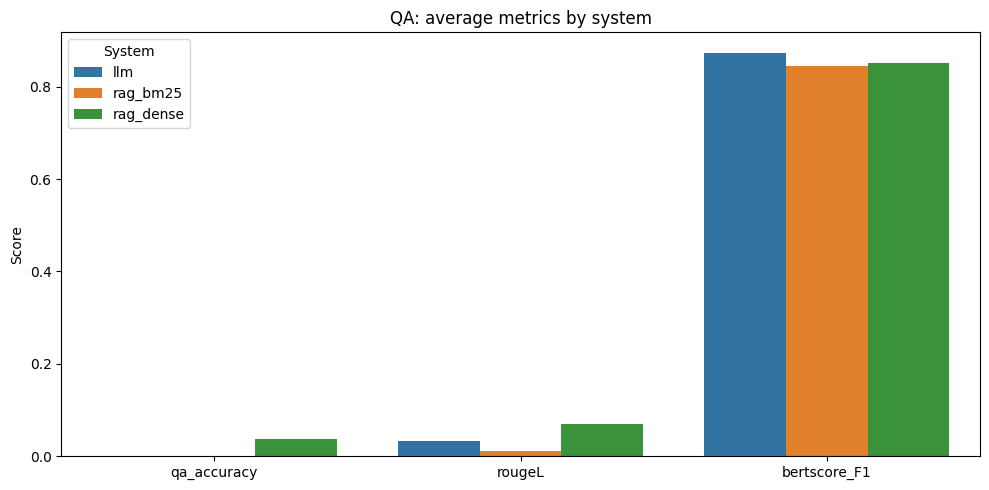

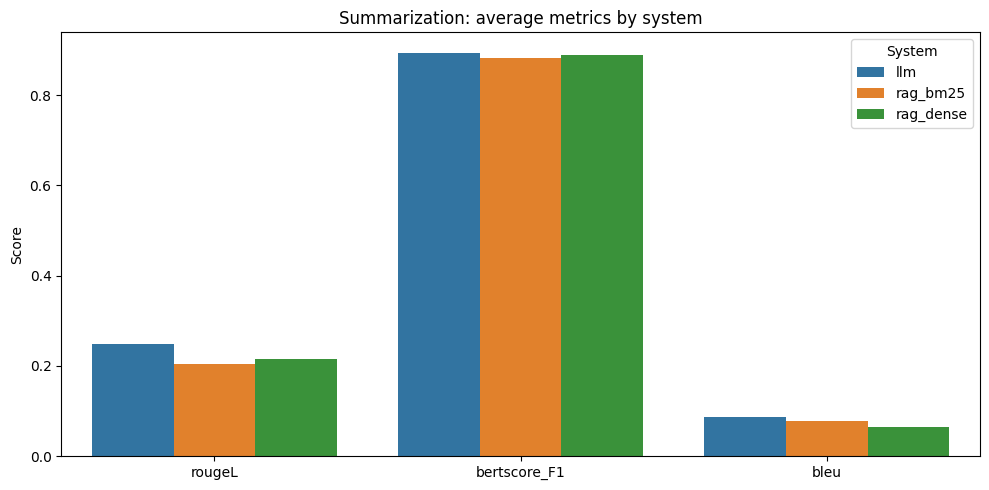

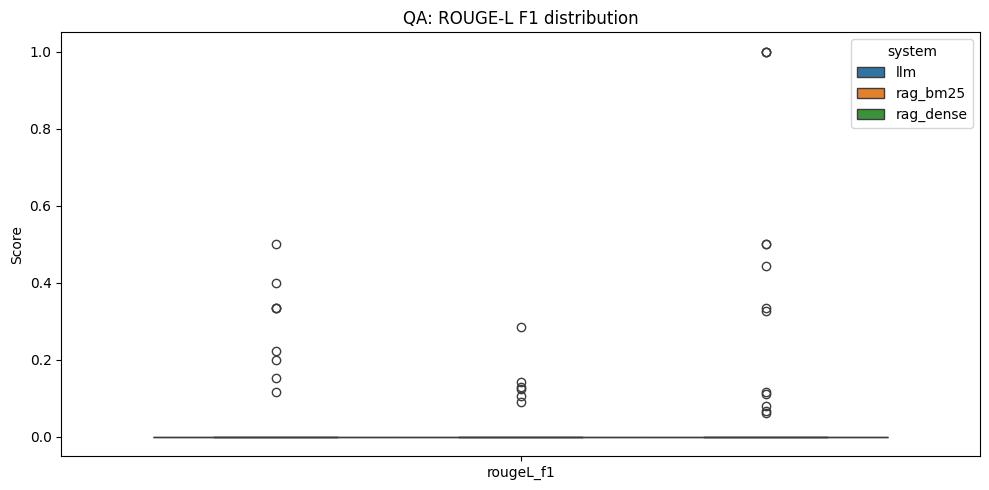

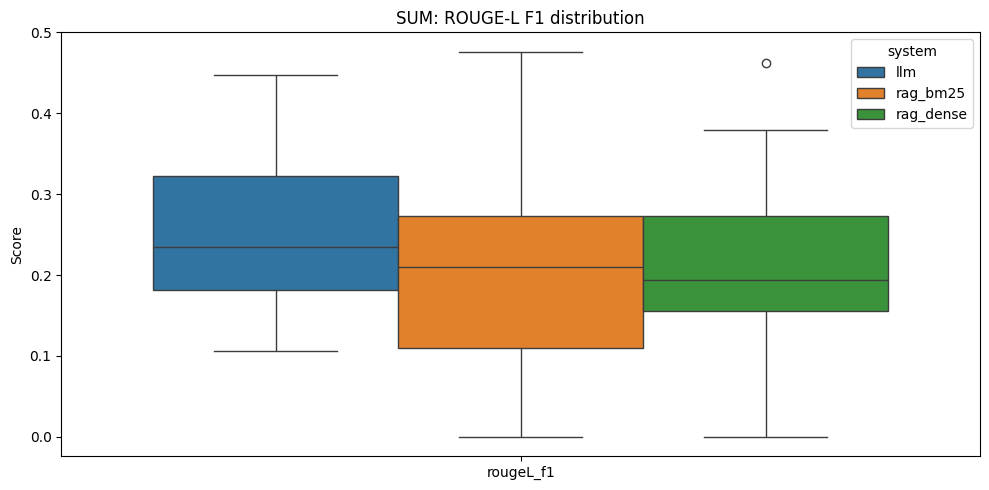

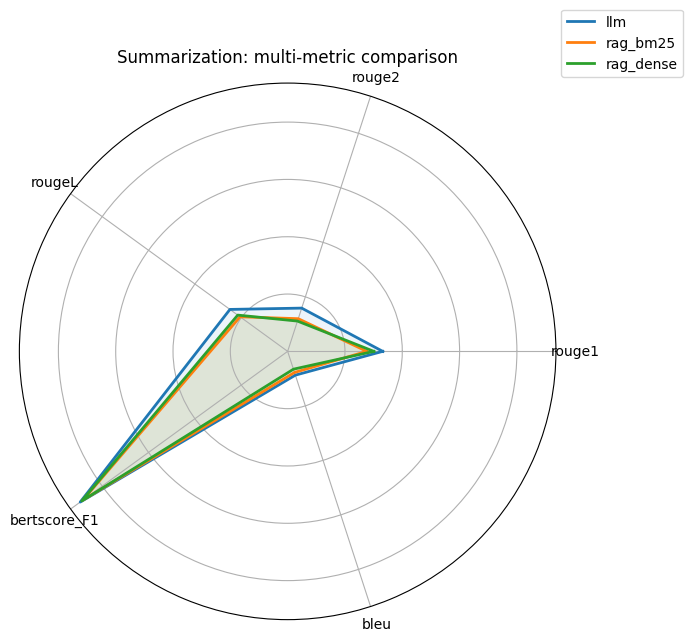

In [13]:
FIG_DIR = ensure_dir(OUT_DIR / "figures")

# 1) Bar charts: average metrics per model

qa_bar = qa_metrics_df[["system", "qa_accuracy", "rougeL", "bertscore_F1"]].copy()
fig = viz.bar_avg_metrics(qa_bar, ["qa_accuracy", "rougeL", "bertscore_F1"], title="QA: average metrics by system")
fig.savefig(FIG_DIR / "qa_bar_avg_metrics.png", dpi=200)

sum_bar = sum_metrics_df[["system", "rougeL", "bertscore_F1", "bleu"]].copy()
# Scale BLEU to 0..1 for comparability in the figure
sum_bar["bleu"] = sum_bar["bleu"] / 100.0
fig = viz.bar_avg_metrics(sum_bar, ["rougeL", "bertscore_F1", "bleu"], title="Summarization: average metrics by system")
fig.savefig(FIG_DIR / "sum_bar_avg_metrics.png", dpi=200)

# 2) Box plots: score distributions (per-example ROUGE-L)
long = all_df[["task", "system", "rougeL_f1"]].rename(columns={"rougeL_f1": "score"})
long["metric"] = "rougeL_f1"

for task in ["qa", "sum"]:
    fig = viz.boxplot_distributions(long[long["task"] == task][["system", "metric", "score"]], title=f"{task.upper()}: ROUGE-L F1 distribution")
    fig.savefig(FIG_DIR / f"{task}_box_rougeL.png", dpi=200)

# 3) Radar chart: multi-metric comparison (summarization)
rad = sum_metrics_df[["system", "rouge1", "rouge2", "rougeL", "bertscore_F1", "bleu"]].copy()
rad["bleu"] = rad["bleu"] / 100.0
fig = viz.radar_multimetric(rad, ["rouge1", "rouge2", "rougeL", "bertscore_F1", "bleu"], title="Summarization: multi-metric comparison")
fig.savefig(FIG_DIR / "sum_radar_multimetric.png", dpi=200)

print("Saved figures to:", FIG_DIR.resolve())


## Manual evaluation (hallucination / correctness)

Annotation scheme (3 labels):
- **correct**
- **partially_correct**
- **incorrect_or_hallucinated**

Why manual evaluation is required:
- Automatic metrics (BLEU/ROUGE/BERTScore) can miss factual errors.
- Hallucinations are *semantic* and *factual* phenomena; human judgment is the gold standard.

### How to annotate
1. This notebook creates a small CSV template under `outputs/manual_annotations_template.csv`.
2. Open it in Excel/Google Sheets.
3. For each row, fill `manual_label` using exactly one of the three labels above.
4. Save as `outputs/manual_annotations_filled.csv`.

Then rerun the next cell to generate:
- **scatter plot** (manual vs ROUGE-L)
- **stacked bar chart** (hallucination breakdown)


Wrote annotation template: D:\FAKS\Opj\LLM_RAG_QnA\outputs\manual_annotations_template.csv
Spearman correlation (manual vs ROUGE-L F1): 0.08970522700074382
Saved manual-eval figures to: D:\FAKS\Opj\LLM_RAG_QnA\outputs\figures


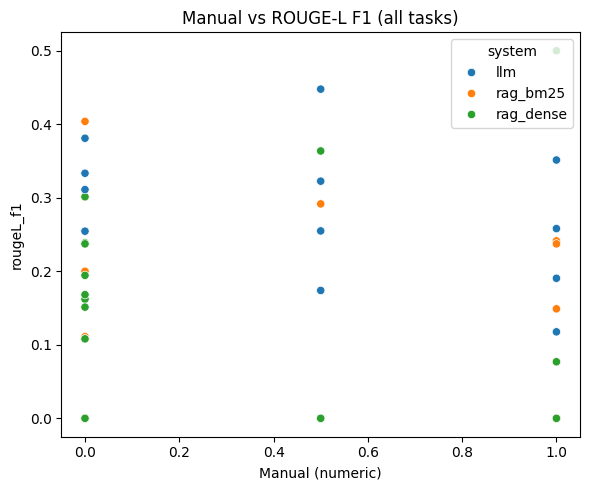

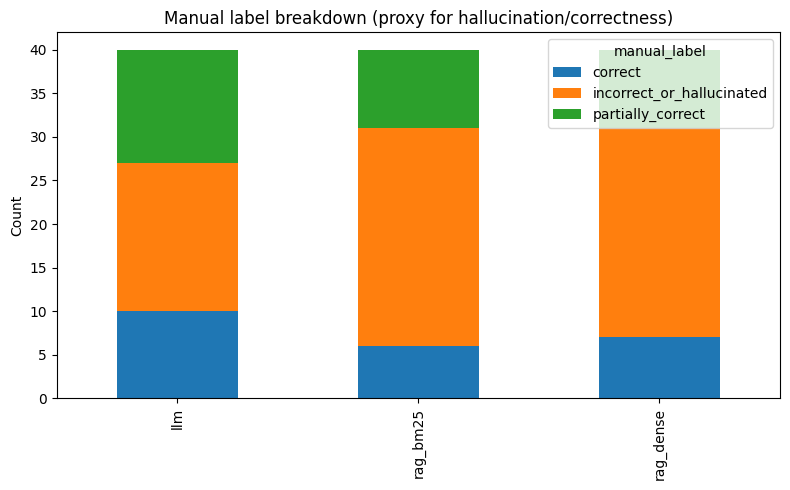

In [14]:
# Create a manageable annotation template (same items across systems)

MANUAL_QA_N = 30
MANUAL_SUM_N = 10

rng = np.random.default_rng(SEED)
qa_ids = qa_df["id"].drop_duplicates().tolist()
sum_ids = sum_df["id"].drop_duplicates().tolist()

qa_sample = rng.choice(qa_ids, size=min(MANUAL_QA_N, len(qa_ids)), replace=False)
sum_sample = rng.choice(sum_ids, size=min(MANUAL_SUM_N, len(sum_ids)), replace=False)

manual_df = all_df[
    ((all_df["task"] == "qa") & (all_df["id"].isin(qa_sample)))
    | ((all_df["task"] == "sum") & (all_df["id"].isin(sum_sample)))
].copy()

manual_df["manual_label"] = ""  # fill this column
manual_template_path = OUT_DIR / "manual_annotations_template.csv"
manual_df.to_csv(manual_template_path, index=False)
print("Wrote annotation template:", manual_template_path.resolve())

# If the filled file exists, load it and generate the remaining required figures
# IMPORTANT: We do NOT trust numeric columns from Excel/Sheets (they can change decimals to commas, etc.).
# We only take manual_label and merge it onto the clean `all_df` computed above.
filled_path = OUT_DIR / "manual_annotations_filled.csv"
if filled_path.exists():
    ann = pd.read_csv(filled_path, sep=None, engine="python", dtype=str)
    ann.columns = [str(c).strip().lstrip("\ufeff") for c in ann.columns]

    required = {"task", "id", "system", "manual_label"}
    missing = sorted(list(required - set(ann.columns)))
    if missing:
        raise ValueError(f"manual_annotations_filled.csv is missing columns: {missing}")

    ann = ann[["task", "id", "system", "manual_label"]].copy()
    ann["manual_label"] = ann["manual_label"].astype(str).str.strip()

    filled = all_df.merge(ann, on=["task", "id", "system"], how="inner")
    filled["manual_numeric"] = manual_label_to_numeric(filled["manual_label"].tolist())

    # Scatter plot: manual vs automatic (ROUGE-L per-example)
    fig = viz.scatter_manual_vs_metric(
        filled.dropna(subset=["manual_numeric", "rougeL_f1"]),
        manual_numeric_col="manual_numeric",
        metric_col="rougeL_f1",
        title="Manual vs ROUGE-L F1 (all tasks)",
    )
    fig.savefig(FIG_DIR / "scatter_manual_vs_rougeL.png", dpi=200)

    # Correlation (Spearman) for reporting
    rho = correlation_manual_vs_metric(filled, manual_col="manual_numeric", metric_col="rougeL_f1")
    print("Spearman correlation (manual vs ROUGE-L F1):", rho)

    # Stacked bar: hallucination breakdown
    fig = viz.stacked_hallucination_breakdown(
        filled[["system", "manual_label"]],
        title="Manual label breakdown (proxy for hallucination/correctness)",
    )
    fig.savefig(FIG_DIR / "stacked_manual_breakdown.png", dpi=200)

    print("Saved manual-eval figures to:", FIG_DIR.resolve())
else:
    print("Fill the template and save as:", filled_path)
